### Import libs and data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
data = pd.read_csv(r'C:\Users\Achilles\PycharmProjects\data\Spotify\spotify-public-dataset.csv')

### Exploratory analysis

In [3]:
data.head()

,message_id,message_type,author_id,author_type,severity,message_body,created_at
0,2391986,ticket,354084,NaN,urgent,@SpotifyCares haha. I love the link to the tra...,2017-11-14T13:53:58+00:00
1,617831,chat,266588,lead,urgent,@SpotifyCares Can you follow me?,2017-11-22T14:17:11+00:00
2,356960,email,200756,lead,low,@SpotifyCares Fingers crossed? How about sayin...,2017-11-29T15:48:37+00:00
3,1118813,ticket,383965,user,low,@SpotifyCares Only FTNICR and Never Too Late a...,2017-10-24T04:44:59+00:00
4,314098,chat,190991,user,urgent,@SpotifyCares Is it that one? https://t.co/ZKp...,2017-10-07T05:54:31+00:00


In [4]:
data.describe()

,message_id
count,1.500000e+04
mean,4.556656e+06
std,6.058574e+07
min,8.500000e+02
25%,8.399548e+05
50%,1.670458e+06
75%,2.246046e+06
max,1.550548e+09


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   message_id    15000 non-null  int64 
 1   message_type  11248 non-null  object
 2   author_id     15000 non-null  object
 3   author_type   9944 non-null   object
 4   severity      15000 non-null  object
 5   message_body  14986 non-null  object
 6   created_at    15000 non-null  object
dtypes: int64(1), object(6)
memory usage: 468.8+ KB


- 14 instances of missing `message_body` drop those
- Quite a few missing data for `message_type` let's impute this with most frequent value (check day of week and hour of day distribution might be informative towards doing smarter imputation)
- Same for `author_type`
- `created_at` hasn't parsed a datetime object, need to fix this. The timestamps are timezone aware so need make sure we pass on this info correctly. From a quick inspection looks like a timezone aware object has been created, in `UTC` timezone.

In [6]:
data.created_at = pd.to_datetime(data.created_at)#.dt.tz_convert('GMT')
data.created_at[0].tzinfo 

<UTC>

Drop empty messages.

In [7]:
data = data.dropna(subset=['message_body'])

Let's drop `message_id` we don't need a unique identifier as a feature.

In [8]:
data = data.drop(columns='message_id')

Let's inspect what values all categorical features can take and what the distribution of tickets looks like.

In [9]:
for col in ['message_type', 'author_type', 'severity']:
    print(col, data[col].dropna().unique())

message_type ['ticket' 'chat' 'email']
author_type ['lead' 'user']
severity ['urgent' 'low' 'medium']


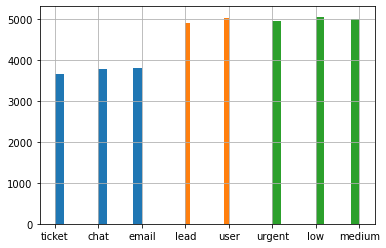

In [10]:
for col in ['message_type', 'author_type', 'severity']:
    data[col].hist()

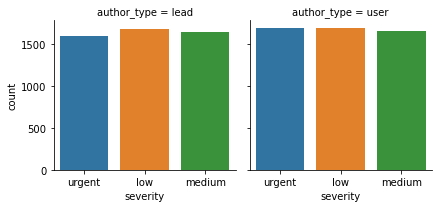

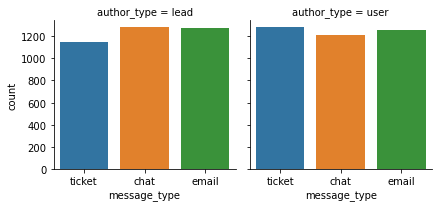

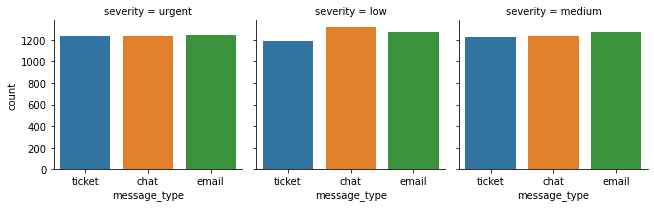

In [11]:
sns.catplot(x='severity', col='author_type', kind='count', data=data, height=3)
sns.catplot(x='message_type', col='author_type', kind='count', data=data, height=3)
sns.catplot(x='message_type', col='severity', kind='count', data=data, height=3)

Ok our data is very evenly distributed overall, no over/under-indexing for particular segments.

Let's extract some additional temporal features from our timestamps.

In [12]:
# inject temporal features
data['dow'] = data['created_at'].dt.day_name()
data['month'] = data['created_at'].dt.month_name()
data['hour'] = data['created_at'].dt.hour
data['doy'] = data['created_at'].apply(lambda x: x.strftime('%j'))
data['weekday'] = ['weekday' if x < 5 else 'weekend' for x in data['created_at'].dt.dayofweek]
data['business_hours'] = ['business_hours' if (7 < x.hour < 19 and x.dayofweek < 5)
                           else 'no_business_hours' for x in data['created_at']]

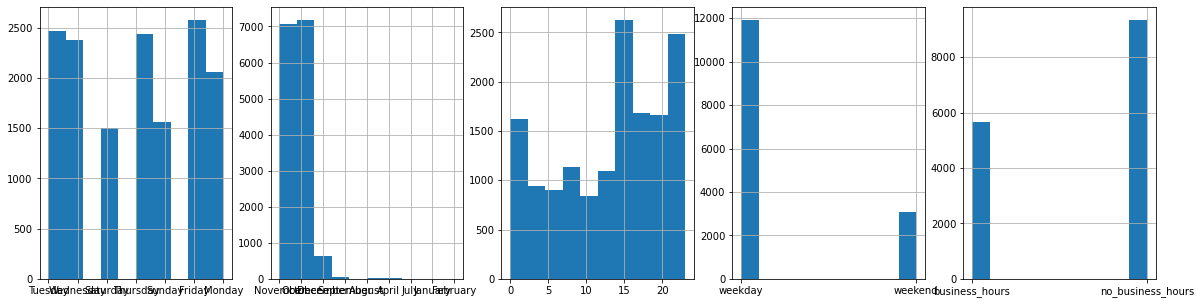

In [13]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=5)
for i, col in enumerate(['dow', 'month', 'hour', 'weekday', 'business_hours']):
    data[col].hist(ax=axes[i], figsize=(20,5))

Now let's examine all time-related aspects of our data.

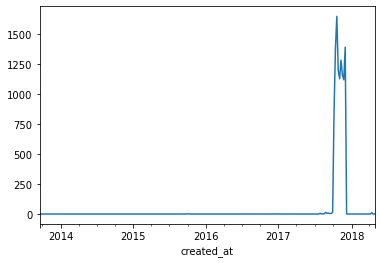

In [14]:
data.resample('W', on='created_at')['message_type'].count().plot.line()

(17440.0, 17505.0)

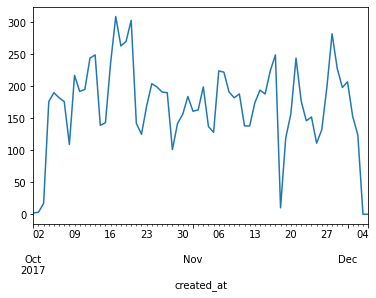

In [15]:
data.resample('D', on='created_at')['message_type'].count().plot.line()
plt.xlim('2017-10-01', '2017-12-05')

The vast majority of our data has been collected in late 2017. Treading on the cautious side let's drop the few data points that are outside of this range as conversational themes tend to change over time. Not sure how relevant this assumption is here but it's a very small amount of data so might as well be safe.

In [16]:
count = data.shape[0]
data = data[(data.created_at >= datetime.datetime(2017, 10, 1, tzinfo=data.created_at.dt.tz)) & 
            (data.created_at <= datetime.datetime(2017, 12, 5, tzinfo=data.created_at.dt.tz))]
print('Dropped %i rows' % (int(count)-int(data.shape[0])))

Dropped 98 rows


A quick search for patterns, see if any segments are over/under indexing in particular times/days etc.

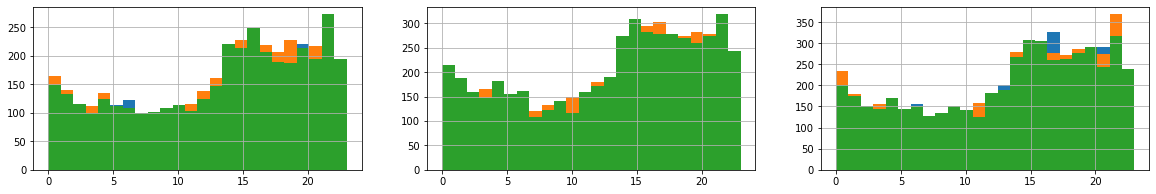

In [17]:
fig, axes = plt.subplots(figsize=(20,3), nrows=1, ncols=3)
for i, col in enumerate(['message_type', 'author_type', 'severity']):
    for value in data[col].unique():
        data[data[col]==value].created_at.dt.hour.hist(ax=axes[i], figsize=(20,3), bins=24)
plt.show()

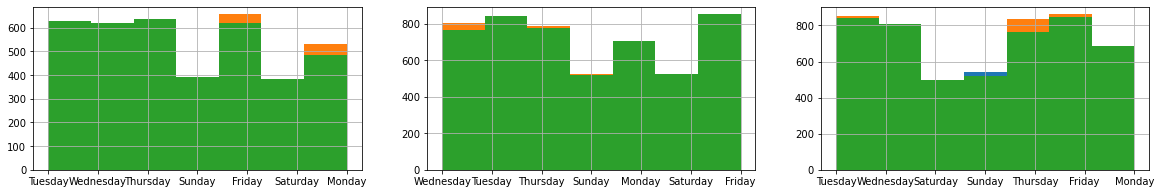

In [18]:
fig, axes = plt.subplots(figsize=(20,3), nrows=1, ncols=3)
for i, col in enumerate(['message_type', 'author_type', 'severity']):
    for value in data[col].unique():
        data[data[col]==value].created_at.dt.day_name().hist(ax=axes[i], figsize=(20,3), bins=7)
plt.show()

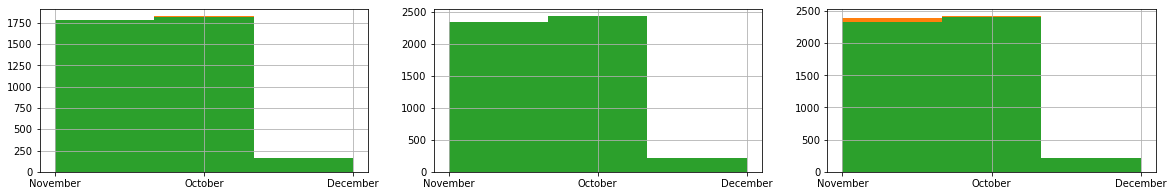

In [19]:
fig, axes = plt.subplots(figsize=(20,3), nrows=1, ncols=3)
for i, col in enumerate(['message_type', 'author_type', 'severity']):
    for value in data[col].unique():
        data[data[col]==value].created_at.dt.month_name().hist(ax=axes[i], figsize=(20,3), bins=3)
plt.show()

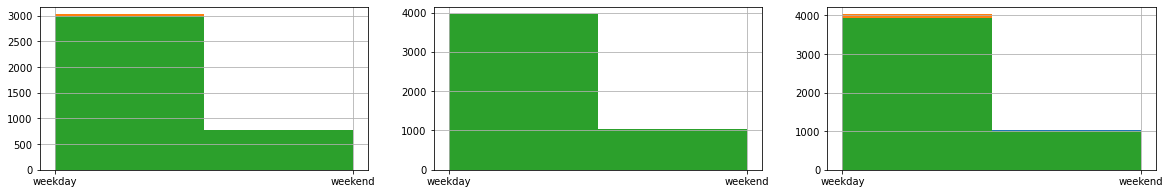

In [20]:
fig, axes = plt.subplots(figsize=(20,3), nrows=1, ncols=3)
for i, col in enumerate(['message_type', 'author_type', 'severity']):
    for value in data[col].unique():
        data[data[col]==value].weekday.hist(ax=axes[i], figsize=(20,3), bins=2)
plt.show()

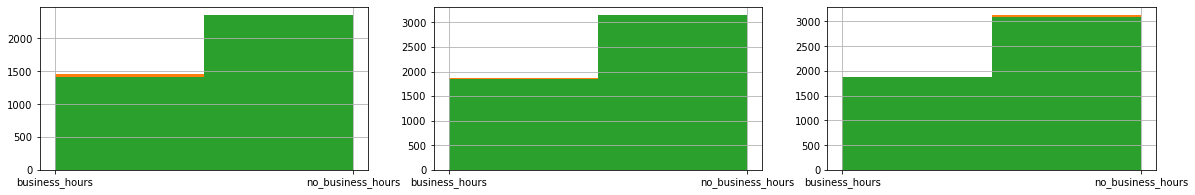

In [21]:
fig, axes = plt.subplots(figsize=(20,3), nrows=1, ncols=3)
for i, col in enumerate(['message_type', 'author_type', 'severity']):
    for value in data[col].unique():
        data[data[col]==value].business_hours.hist(ax=axes[i], figsize=(20,3), bins=2)
plt.show()

Nothing really stands out too much.

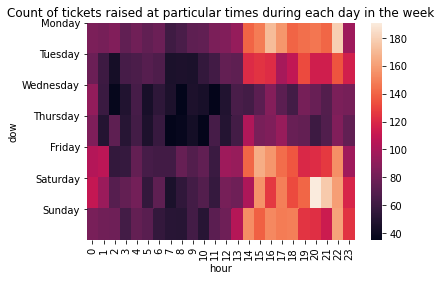

In [22]:
sns.heatmap(pd.crosstab(data.dow, data.hour))
plt.title('Count of tickets raised at particular times during each day in the week')
plt.yticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0) 
plt.show()

Most tickets are coming in in afternoon, evening and night hours.

### Let's dig in the actuall interesting data
First let's have a peek at some samples.

In [23]:
data.head()

,message_type,author_id,author_type,severity,message_body,created_at,dow,month,hour,doy,weekday,business_hours
0,ticket,354084,NaN,urgent,@SpotifyCares haha. I love the link to the tra...,2017-11-14 13:53:58+00:00,Tuesday,November,13,318,weekday,business_hours
1,chat,266588,lead,urgent,@SpotifyCares Can you follow me?,2017-11-22 14:17:11+00:00,Wednesday,November,14,326,weekday,business_hours
2,email,200756,lead,low,@SpotifyCares Fingers crossed? How about sayin...,2017-11-29 15:48:37+00:00,Wednesday,November,15,333,weekday,business_hours
3,ticket,383965,user,low,@SpotifyCares Only FTNICR and Never Too Late a...,2017-10-24 04:44:59+00:00,Tuesday,October,4,297,weekday,no_business_hours
4,chat,190991,user,urgent,@SpotifyCares Is it that one? https://t.co/ZKp...,2017-10-07 05:54:31+00:00,Saturday,October,5,280,weekend,no_business_hours


In [24]:
samples = 10
sampled_data = data.sample(samples)
for i in range(samples):
    display(sampled_data.message_body[:samples].values[i])

'@SpotifyCares is there a way 2 edit the "release radar" playlist. Mine keeps adding Spanish music &amp; I don\'t listen to Spanish music'

"@SpotifyCares Hi Spotify, this doesn't answer my question. I want to know if I can retrieve lost messages :("

"@SpotifyCares It's been 4 years (&amp; 666 votes) since people have asked for Spotify Connect support on the Roku, when will you implement this?"

'@SpotifyCares @115888 does spotify have an equalizer yet?'

'@SpotifyCares The option to add this entire playlist, to another playlist, rather than adding it song by song, is gone? https://t.co/oYkpSqGKSM'

'@SpotifyCares I’m trying to sync my Spotify account with my Alexa and it keeps saying I don’t have an email address associated w/ FB.  I also can’t log in to my Spotify account.'

'@SpotifyCares Cheers Samsung s7 edge android 7.0 and Spotify premium version 8. Something. 🖒'

'@SpotifyCares So much for ‘digital remaster’ eh? :/'

'@SpotifyCares when my name is searched on spotify it comes up twice and one of them has nothing on it. Why is that?'

'Hey @115888 @SpotifyCares, why is it still so complicated and unintuitive to get a playlist from a link into the desktop app?'

I've seen some entries that are not in English, the process I follow here only applies to English, given that language identification is a tough problem in its own right, I won't address this here, leave it out of scope, ingest the non-English data as usual as we can't easily identify and drop.

Let's extract the Twitter handles as a separate feature and remove it from the message body afterwards.

In [25]:
import re
handle = re.compile(r'@([^\s:]+)')
data['handle'] = data['message_body'].apply(lambda x: handle.findall(x)[0])

<ipython-input-25-ce8e9b805b4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['handle'] = data['message_body'].apply(lambda x: handle.findall(x)[0])


Looks like the overwhelming majority are addressed at `@SpotifyCares` 

Let's also clean those that we didn't parse properly.

In [26]:
data.groupby('handle').size().sort_values(ascending=False)

handle
SpotifyCares     13706
115888             505
SpotifyCares,       79
117153              51
SpotifyCares.       32
                 ...  
5413                 1
547719               1
547745               1
549077               1
1008                 1
Length: 357, dtype: int64

In [27]:
data.loc[data['handle'].str.contains('SpotifyCares'), 'handle'] = 'SpotifyCares'

c:\users\achilles\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
data.loc[:, 'message_body'] = data['message_body'].str.replace(r'@([^\s:]+)', r'')

Let's do the same for URLs

In [29]:
url = re.compile(r'http\S+')
data.loc[:, 'url'] = data['message_body'].apply(lambda x: url.findall(x)[0] if len(url.findall(x))>0 else np.nan)
data.loc[:, 'includes_url'] = data['message_body'].apply(lambda x: 1 if r'http' in x else 0)
data.loc[:, 'message_body'] = data['message_body'].str.replace(r'http\S+', r'')

c:\users\achilles\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Let's get some additional basic features

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import operator
from nltk.corpus import stopwords

stop = stopwords.words('english')
sid = SentimentIntensityAnalyzer()

def get_sentiment_with_max_score(text):
  score = sid.polarity_scores(text)
  score.pop('compound')
  return max(score.items(), key=operator.itemgetter(1))[0]

def avg_word(sentence):
    words = sentence.split()
    if len(words)>0:
        return (sum(len(word) for word in words)/len(words))
    else:
        return 0

data.loc[:, 'polarity'] = data['message_body'].map(lambda text: get_sentiment_with_max_score(text))
data.loc[:, 'len'] = data['message_body'].astype(str).apply(len)
data.loc[:, 'word_count'] = data['message_body'].apply(lambda x: len(str(x).split()))
data.loc[:, 'avg_word'] = data['message_body'].apply(lambda x: avg_word(x))
data.loc[:, 'stopwords'] = data['message_body'].apply(lambda x: len([x for x in x.split() if x in stop]))
data.loc[:, 'number_cnt'] = data['message_body'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data.loc[:, 'contains_numbers'] = data['message_body'].apply(lambda x: 1 if x.isdigit() else 0)
data.loc[:, 'contains_upper'] = data['message_body'].apply(lambda x: 1 if x.isupper() else 0)
data.loc[:, 'upper_cnt'] = data['message_body'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

c:\users\achilles\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\achilles\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


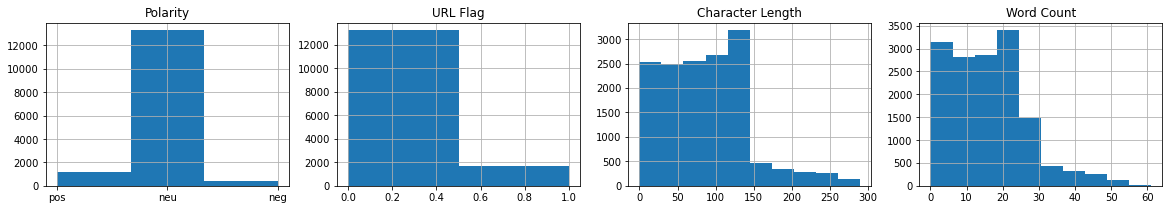

In [31]:
fig, axes = plt.subplots(figsize=(20,3), nrows=1, ncols=4)
data.polarity.hist(bins=3, ax=axes[0], figsize=(20,3))
data.includes_url.hist(bins=2,  ax=axes[1], figsize=(20,3))
data.len.hist(ax=axes[2], figsize=(20,3))
data.word_count.hist(ax=axes[3], figsize=(20,3))
axes[0].title.set_text('Polarity')
axes[1].title.set_text('URL Flag')
axes[2].title.set_text('Character Length')
axes[3].title.set_text('Word Count')
plt.show()

Size of our word corpus in this dataset

In [34]:
len(set(' '.join(data['message_body']).split()))

23295

Pre-stop word extraction

In [35]:
freq_words = pd.Series(' '.join(data['message_body']).split()).value_counts()[:10]
freq_words

I      7879
to     6906
the    6742
my     5500
a      4193
and    4123
it     3195
on     3015
for    2865
is     2772
dtype: int64

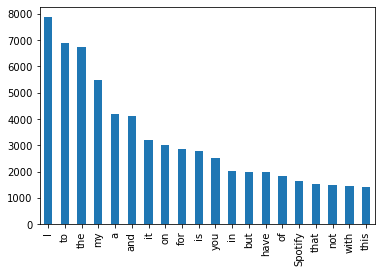

In [36]:
pd.Series(' '.join(data['message_body']).split()).value_counts()[:20].plot.bar()

Post stop-word extraction

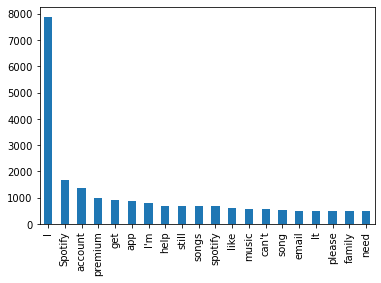

In [37]:
import nltk
# nltk.download("stopwords")

stop_words = stopwords.words('english')
pd.Series([x for x in ' '.join(data['message_body']).split() if x not in stop_words]).value_counts()[:20].plot.bar()

Seems that people like a lot to tweet about themselves right?

In [38]:
rare_words = pd.Series(' '.join(data['message_body']).split()).value_counts()[-10:]
rare_words

ins           1
Quarry        1
shadows,      1
Blancmange    1
reggaeton     1
👏🏻👏🏻👏🏻👏🏻      1
Hej!          1
Ass           1
12-15         1
maiden        1
dtype: int64

Unsurprisingly some broken words and strings here. May consider to strip special characters.

In [39]:
# freq = list(freq_words.index)
# rare = list(rare_words.index)
# w = freq + rare
# data[:, 'message_body'] = data['message_body'].apply(lambda x: " ".join(x for x in x.split() if x not in w))

Spelling correction

In [40]:
# from textblob import TextBlob
# data.loc[:, 'message_body'] = data['message_body'].apply(lambda x: str(TextBlob(x).correct()))

### Things to try next

In [41]:
## Data Cleaning
# lowercase
# remove punctuation
# remove stopwords
# words = [word for word in tokens if word.isalpha()] # remove any non alphabetic tokens

## Feature Engineering
# sentences = sent_tokenize(text)
# tokens = word_tokenize(text)
# lemmatize
# n-grams
# term frequency
# inverse doc frequency
# tf - inv doc freq
# bow
# embeddings
# part of speech

### EDA on text features

In [42]:
# get mean word count and polarity by categories

### Export data

In [48]:
data = data.dropna(subset=['message_body'])
data.to_csv('modelling_data.csv', index=False)